
# KKBOX Churn Prediction Pipeline
This project is part of the KKBOX Churn Prediction competition hosted on Kaggle in conjunction with the 11th ACM International Conference on Web Search and Data Mining (WSDM 2018). The goal is to build an algorithm that predicts whether a subscription user will churn using a donated dataset from KKBOX.

https://www.kaggle.com/c/kkbox-churn-prediction-challenge

## Project Overview
Accurately predicting customer churn is crucial for subscription-based businesses like KKBOX, Asia’s leading music streaming service. The ability to forecast whether a user will renew or cancel their subscription helps in formulating strategies to retain customers and maximize profits.

In this competition, the task is to predict whether a user will churn after their subscription expires, using various user behaviors and transaction data.

## Dataset
The dataset includes several files:

- `train.csv` / `train_v2.csv`: Training data with user ids and churn labels.
  - `msno`: User ID
  - `is_churn`: Target variable; `1` indicates churn, `0` indicates renewal
- `sample_submission_zero.csv` / `sample_submission_v2.csv`: Test data with user ids and expected format for submission.
- `transactions.csv` / `transactions_v2.csv`: Contains transaction details of users.
  - `msno`: User ID
  - `payment_method_id`: Payment method
  - `payment_plan_days`: Length of the membership plan in days
  - `plan_list_price`: Plan list price in New Taiwan Dollar (NTD)
  - `actual_amount_paid`: Actual amount paid in NTD
  - `is_auto_renew`: Whether the membership is auto-renewed
  - `transaction_date`: Date of the transaction
  - `membership_expire_date`: Membership expiration date
  - `is_cancel`: Indicates if the user canceled the membership
- `user_logs.csv` / `user_logs_v2.csv`: Daily user logs describing listening behaviors.
  - `msno`: User ID
  - `date`: Date of the log entry
  - `num_25`: Number of songs played less than 25% of the song length
  - `num_50`: Number of songs played between 25% and 50%
  - `num_75`: Number of songs played between 50% and 75%
  - `num_985`: Number of songs played between 75% and 98.5%
  - `num_100`: Number of songs played over 98.5%
  - `num_unq`: Number of unique songs played
  - `total_secs`: Total seconds played
- `members.csv` / `members_v3.csv`: Contains user information.
  - `msno`: User ID
  - `city`, `bd`, `gender`, `registered_via`: User demographics
  - `registration_init_time`: User registration time

## Project Pipeline
1. **Data Preprocessing**: Cleaning and transforming the data to handle missing values, outliers, and feature engineering.
2. **Feature Engineering**: Creating new features based on user behavior and transaction history.
3. **Model Training**: Using machine learning models to predict churn.
4. **Evaluation**: Measuring the model performance using appropriate metrics.

## Results
- Achieved an accuracy of over 90% in predicting user churn using lightGBM.
- Used feature importance analysis to understand the impact of various features on churn prediction. Permutation importance and surrogate model show that `membership_expire_day` is the most important feature.


# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import re

# visualiation libraries

import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline as Pipe # distinguish from imblearn pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

# model interpretablity
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
import shap

# algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from scikeras.wrappers import KerasClassifier

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin #inheritance class for custom transformers
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor

# metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# saving the pipeline
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
train_df = pd.read_csv('./input/train_v2.csv')
tnx_df = pd.read_csv('./input/transactions_v2.csv')
user_logs_df = pd.read_csv('./input/user_logs_v2.csv')
members_df = pd.read_csv('./input/members_v3.csv')

# 2. Data explore

In [4]:
# Checking shapes
print("Train DataFrame shape:", train_df.shape)
print("Transactions DataFrame shape:", tnx_df.shape)
print("User Logs DataFrame shape:", user_logs_df.shape)
print("Members DataFrame shape:", members_df.shape)


Train DataFrame shape: (970960, 2)
Transactions DataFrame shape: (1431009, 9)
User Logs DataFrame shape: (18396362, 9)
Members DataFrame shape: (6769473, 6)


In [5]:

# Checking for null values
print("Null values in Train DataFrame:")
print(train_df.isnull().sum())

print("\nNull values in Transactions DataFrame:")
print(tnx_df.isnull().sum())

print("\nNull values in User Logs DataFrame:")
print(user_logs_df.isnull().sum())

print("\nNull values in Members DataFrame:")
print(members_df.isnull().sum())

# Checking for duplicates
print("\nDuplicates in Train DataFrame:", train_df.duplicated().sum())
print("Duplicates in Transactions DataFrame:", tnx_df.duplicated().sum())
print("Duplicates in User Logs DataFrame:", user_logs_df.duplicated().sum())
print("Duplicates in Members DataFrame:", members_df.duplicated().sum())


Null values in Train DataFrame:
msno        0
is_churn    0
dtype: int64

Null values in Transactions DataFrame:
msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

Null values in User Logs DataFrame:
msno          0
date          0
num_25        0
num_50        0
num_75        0
num_985       0
num_100       0
num_unq       0
total_secs    0
dtype: int64

Null values in Members DataFrame:
msno                            0
city                            0
bd                              0
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

Duplicates in Train DataFrame: 0
Duplicates in Transactions DataFrame: 0
Duplicates in User Logs DataFrame: 0
Duplicates in Members DataFrame: 0


In [6]:
# Checking for duplicates in the 'msno' column of each DataFrame
print("Duplicates in 'msno' column of Train DataFrame:", train_df['msno'].duplicated().sum())
print("Duplicates in 'msno' column of Transactions DataFrame:", tnx_df['msno'].duplicated().sum())
print("Duplicates in 'msno' column of User Logs DataFrame:", user_logs_df['msno'].duplicated().sum())
print("Duplicates in 'msno' column of Members DataFrame:", members_df['msno'].duplicated().sum())


Duplicates in 'msno' column of Train DataFrame: 0
Duplicates in 'msno' column of Transactions DataFrame: 233959
Duplicates in 'msno' column of User Logs DataFrame: 17292468
Duplicates in 'msno' column of Members DataFrame: 0


In [7]:
#understand the pattern of duplicate msno column
tnx_record = tnx_df[tnx_df['msno'] == '++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=']
tnx_record

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
14240,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150107,20170612,0
35729,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20151009,20190911,0
85921,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150207,20170910,0
93093,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,20150409,20180507,0
100127,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20151109,20191212,0
171355,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150109,20170713,0
178425,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,20150507,20180607,0
220782,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,20150509,20180808,0
249717,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150209,20171008,0


In [8]:
#understand the pattern of duplicate msno column
user_logs_record = user_logs_df[user_logs_df['msno'] == '++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=']
user_logs_record

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
359394,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170330,10,7,0,6,9,32,4262.755
1085212,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170319,1,0,0,1,0,2,218.748
3775402,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170327,7,0,0,1,25,27,5690.713
4289036,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170323,38,0,0,3,20,49,5021.566
5251887,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170303,0,0,0,0,3,3,633.000
5633223,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170309,12,1,1,3,38,41,9697.259
5914502,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170310,3,2,1,1,36,24,9736.659
7699772,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170302,22,8,1,3,45,65,12613.564
7759024,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170304,11,1,1,1,22,31,5451.310
8651452,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,20170318,19,4,1,3,11,24,4194.018


The plot shows it is a imbalance dataset

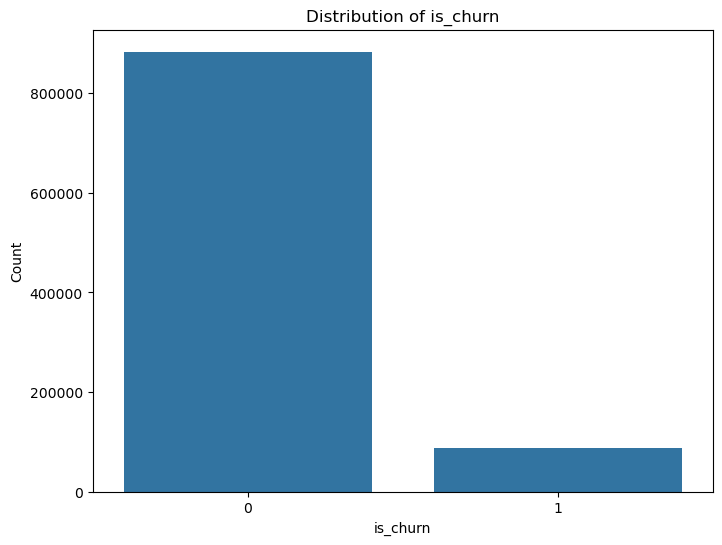

In [9]:

# Plotting the distribution of 'is_churn'
plt.figure(figsize=(8, 6))
sns.countplot(x='is_churn', data=train_df)
plt.title('Distribution of is_churn')
plt.xlabel('is_churn')
plt.ylabel('Count')
plt.show()


In [10]:
tnx_df.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06
mean,3.791835e+01,6.601770e+01,2.817870e+02,2.813172e+02,7.853025e-01,2.016848e+07,2.017110e+07,2.455121e-02
std,4.964805e+00,1.024864e+02,4.351861e+02,4.354200e+02,4.106124e-01,4.858797e+03,3.032367e+03,1.547529e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,2.016042e+07,0.000000e+00
25%,3.600000e+01,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.017023e+07,2.017041e+07,0.000000e+00
50%,4.000000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017031e+07,2.017042e+07,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017032e+07,2.017050e+07,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017033e+07,2.036102e+07,1.000000e+00


In [11]:
user_logs_df.describe()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
mean,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.028246e+01,2.903615e+01,7.904814e+03
std,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.203641e+01,3.219866e+01,1.013632e+04
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03
max,2.017033e+07,5.639000e+03,9.120000e+02,5.080000e+02,1.561000e+03,4.110700e+04,4.925000e+03,9.194059e+06


In [12]:
members_df.describe()

,city,bd,registered_via,registration_init_time
count,6.769473e+06,6.769473e+06,6.769473e+06,6.769473e+06
mean,3.847358e+00,9.795794e+00,5.253069e+00,2.014518e+07
std,5.478359e+00,1.792590e+01,2.361398e+00,2.318601e+04
min,1.000000e+00,-7.168000e+03,-1.000000e+00,2.004033e+07
25%,1.000000e+00,0.000000e+00,4.000000e+00,2.014042e+07
50%,1.000000e+00,0.000000e+00,4.000000e+00,2.015101e+07
75%,4.000000e+00,2.100000e+01,7.000000e+00,2.016060e+07
max,2.200000e+01,2.016000e+03,1.900000e+01,2.017043e+07


In [13]:
members_df.head(10)

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
5,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,male,9,20110916
6,jNCGK78YkTyId3H3wFavcBLDmz7pfqlvCfUKf4G1Lw4=,1,0,NaN,7,20110916
7,WH5Jq4mgtfUFXh2yz+HrcTXKS4Oess4k4W3qKolAeb0=,5,34,male,9,20110916
8,tKmbR4X5VXjHmxERrckawEMZ4znVy1lAQIR1vV5rdNk=,5,19,male,9,20110917
9,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918


# 3. Feature engineering

In [15]:
transactions_v2 = tnx_df.groupby('msno', as_index = False).agg({'payment_method_id': lambda x:x.value_counts().index[0],#get mode
                                                                'payment_plan_days': 'max',
                                                                'plan_list_price': 'max',
                                                                'actual_amount_paid': 'max',
                                                                'is_auto_renew': lambda x:x.value_counts().index[0],#get mode
                                                                'transaction_date': 'min',
                                                                'membership_expire_date': 'max',
                                                               'is_cancel': lambda x:x.value_counts().index[0]})#get mode

In [16]:
transactions_v2.head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,20161023,20180206,0
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170315,20170415,0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,20170228,20170519,0
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20170326,20170426,0
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,20170315,20170415,0
5,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,39,30,149,149,1,20170228,20170523,0
6,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,14,30,149,149,1,20170228,20170504,0
7,++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY=,32,410,1788,1788,0,20160704,20170821,0
8,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,41,30,149,149,1,20170320,20170420,0
9,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,38,30,149,149,0,20170327,20170426,0


In [17]:
user_logs_v2 = user_logs_df.groupby('msno', as_index = False).agg({
    'date': 'max',
    'num_25': 'sum',
    'num_50': 'sum',
    'num_75': 'sum',
    'num_985': 'sum',
    'num_100': 'sum',
    'num_unq': 'max',
    'total_secs': 'sum'})

In [18]:
user_logs_v2['percent_25'] = user_logs_v2['num_25']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_50'] = user_logs_v2['num_50']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_100'] = (user_logs_v2['num_985']+user_logs_v2['num_100'])/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])

In [19]:
user_logs_v3 = user_logs_v2.drop(columns = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [20]:
dataset_train = train_df.merge(members_df, on = 'msno', how = 'left').merge(transactions_v2, on = 'msno', how = 'left').merge(user_logs_v3, on = 'msno', how = 'left')

In [21]:
dataset_train['registration_init_time'] = pd.to_datetime(dataset_train['registration_init_time'], format = '%Y%m%d')
dataset_train['transaction_date'] = pd.to_datetime(dataset_train['transaction_date'], format = '%Y%m%d')
dataset_train['membership_expire_date'] = pd.to_datetime(dataset_train['membership_expire_date'], format = '%Y%m%d')
dataset_train['date'] = pd.to_datetime(dataset_train['date'], format = '%Y%m%d')

In [22]:
dataset_train['registration_day'] = (dataset_train['membership_expire_date'].max() - dataset_train['registration_init_time']).dt.days
dataset_train['transaction_day'] = (dataset_train['membership_expire_date'].max() - dataset_train['transaction_date']).dt.days
dataset_train['membership_expire_day'] = (dataset_train['membership_expire_date'].max() - dataset_train['membership_expire_date']).dt.days
dataset_train['last_play_day'] = (dataset_train['membership_expire_date'].max() - dataset_train['date']).dt.days
# create new day columns for modelling purpose

In [24]:
missing_value  = dataset_train.isna().sum()
missing_value

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time    109993
payment_method_id          37382
payment_plan_days          37382
plan_list_price            37382
actual_amount_paid         37382
is_auto_renew              37382
transaction_date           37382
membership_expire_date     37382
is_cancel                  37382
date                      216409
num_unq                   216409
total_secs                216409
percent_25                216409
percent_50                216409
percent_100               216409
registration_day          109993
transaction_day            37382
membership_expire_day      37382
last_play_day             216409
dtype: int64

In [25]:
dataset_train_v2 = dataset_train.drop(columns = ['msno', 'gender', 'bd', 'registration_init_time', 'transaction_date', 'membership_expire_date', 'date'])
# remove gender and age since people on kaggle said it is not accuracate

In [26]:
dataset_train_v2.head(10)

,is_churn,city,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_unq,total_secs,percent_25,percent_50,percent_100,registration_day,transaction_day,membership_expire_day,last_play_day
0,1,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,158.0,80598.557,0.338182,0.041818,0.596364,3524.0,NaN,NaN,2332.0
1,1,13.0,3.0,36.0,30.0,180.0,180.0,0.0,0.0,9.0,6986.509,0.000000,0.125000,0.812500,3524.0,2350.0,2319.0,2341.0
2,1,13.0,3.0,17.0,90.0,300.0,300.0,0.0,0.0,82.0,67810.467,0.430631,0.102703,0.409009,3520.0,2350.0,2254.0,2330.0
3,1,1.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,3507.0,2931.0,2047.0,NaN
4,1,13.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,62.0,239882.241,0.009128,0.007099,0.979716,3491.0,2511.0,2159.0,2330.0
5,1,22.0,3.0,40.0,30.0,149.0,149.0,1.0,1.0,22.0,10110.665,0.122449,0.020408,0.836735,3490.0,2345.0,2347.0,2343.0
6,1,1.0,7.0,41.0,30.0,99.0,99.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3487.0,2354.0,2354.0,NaN
7,1,9.0,3.0,38.0,410.0,1788.0,1788.0,0.0,0.0,72.0,290831.795,0.066838,0.017138,0.890317,3483.0,2337.0,1922.0,2330.0
8,1,13.0,9.0,38.0,90.0,477.0,477.0,0.0,0.0,99.0,179129.056,0.260519,0.077887,0.623098,3473.0,2354.0,2232.0,2330.0
9,1,13.0,7.0,40.0,30.0,149.0,149.0,1.0,0.0,170.0,97597.540,0.514673,0.038375,0.434537,3457.0,2363.0,2275.0,2330.0


In [27]:
# Check for missing values in X_train
missing_values = dataset_train_v2.isna().sum()

print("Missing values in X_train:")
print(missing_values)

Missing values in X_train:
is_churn                      0
city                     109993
registered_via           109993
payment_method_id         37382
payment_plan_days         37382
plan_list_price           37382
actual_amount_paid        37382
is_auto_renew             37382
is_cancel                 37382
num_unq                  216409
total_secs               216409
percent_25               216409
percent_50               216409
percent_100              216409
registration_day         109993
transaction_day           37382
membership_expire_day     37382
last_play_day            216409
dtype: int64


In [28]:
X = dataset_train_v2.drop(columns=['is_churn'])
y = dataset_train_v2['is_churn']

check small cateogoties

In [29]:
cat_cols = ['city', 'registered_via', 'payment_method_id', 'payment_plan_days', 'is_auto_renew', 'is_cancel']

# Loop through each categorical column to calculate value counts and percentages
for col in cat_cols:
    print(f"Column: {col}")
    value_counts = X[col].value_counts(dropna=False)  # Including NaN values
    percentages = X[col].value_counts(normalize=True, dropna=False) * 100  # Percentages including NaN
    result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
    print(result)
    print("\n" + "-"*40 + "\n")



Column: city
       Count  Percentage
city                    
1.0   442598   45.583546
NaN   109993   11.328273
13.0   97136   10.004120
5.0    70706    7.282071
4.0    47227    4.863949
15.0   43187    4.447866
22.0   41991    4.324689
6.0    26066    2.684560
14.0   20013    2.061156
12.0   11383    1.172345
9.0     9526    0.981091
11.0    9138    0.941130
18.0    7792    0.802505
8.0     7589    0.781598
10.0    6470    0.666351
17.0    5476    0.563978
21.0    5199    0.535449
3.0     5057    0.520825
7.0     2652    0.273132
16.0     944    0.097223
20.0     677    0.069725
19.0     140    0.014419

----------------------------------------

Column: registered_via
                 Count  Percentage
registered_via                    
7.0             462684   47.652220
9.0             235689   24.273811
NaN             109993   11.328273
3.0             106459   10.964303
4.0              52744    5.432150
13.0              3391    0.349242

----------------------------------------

check outliers

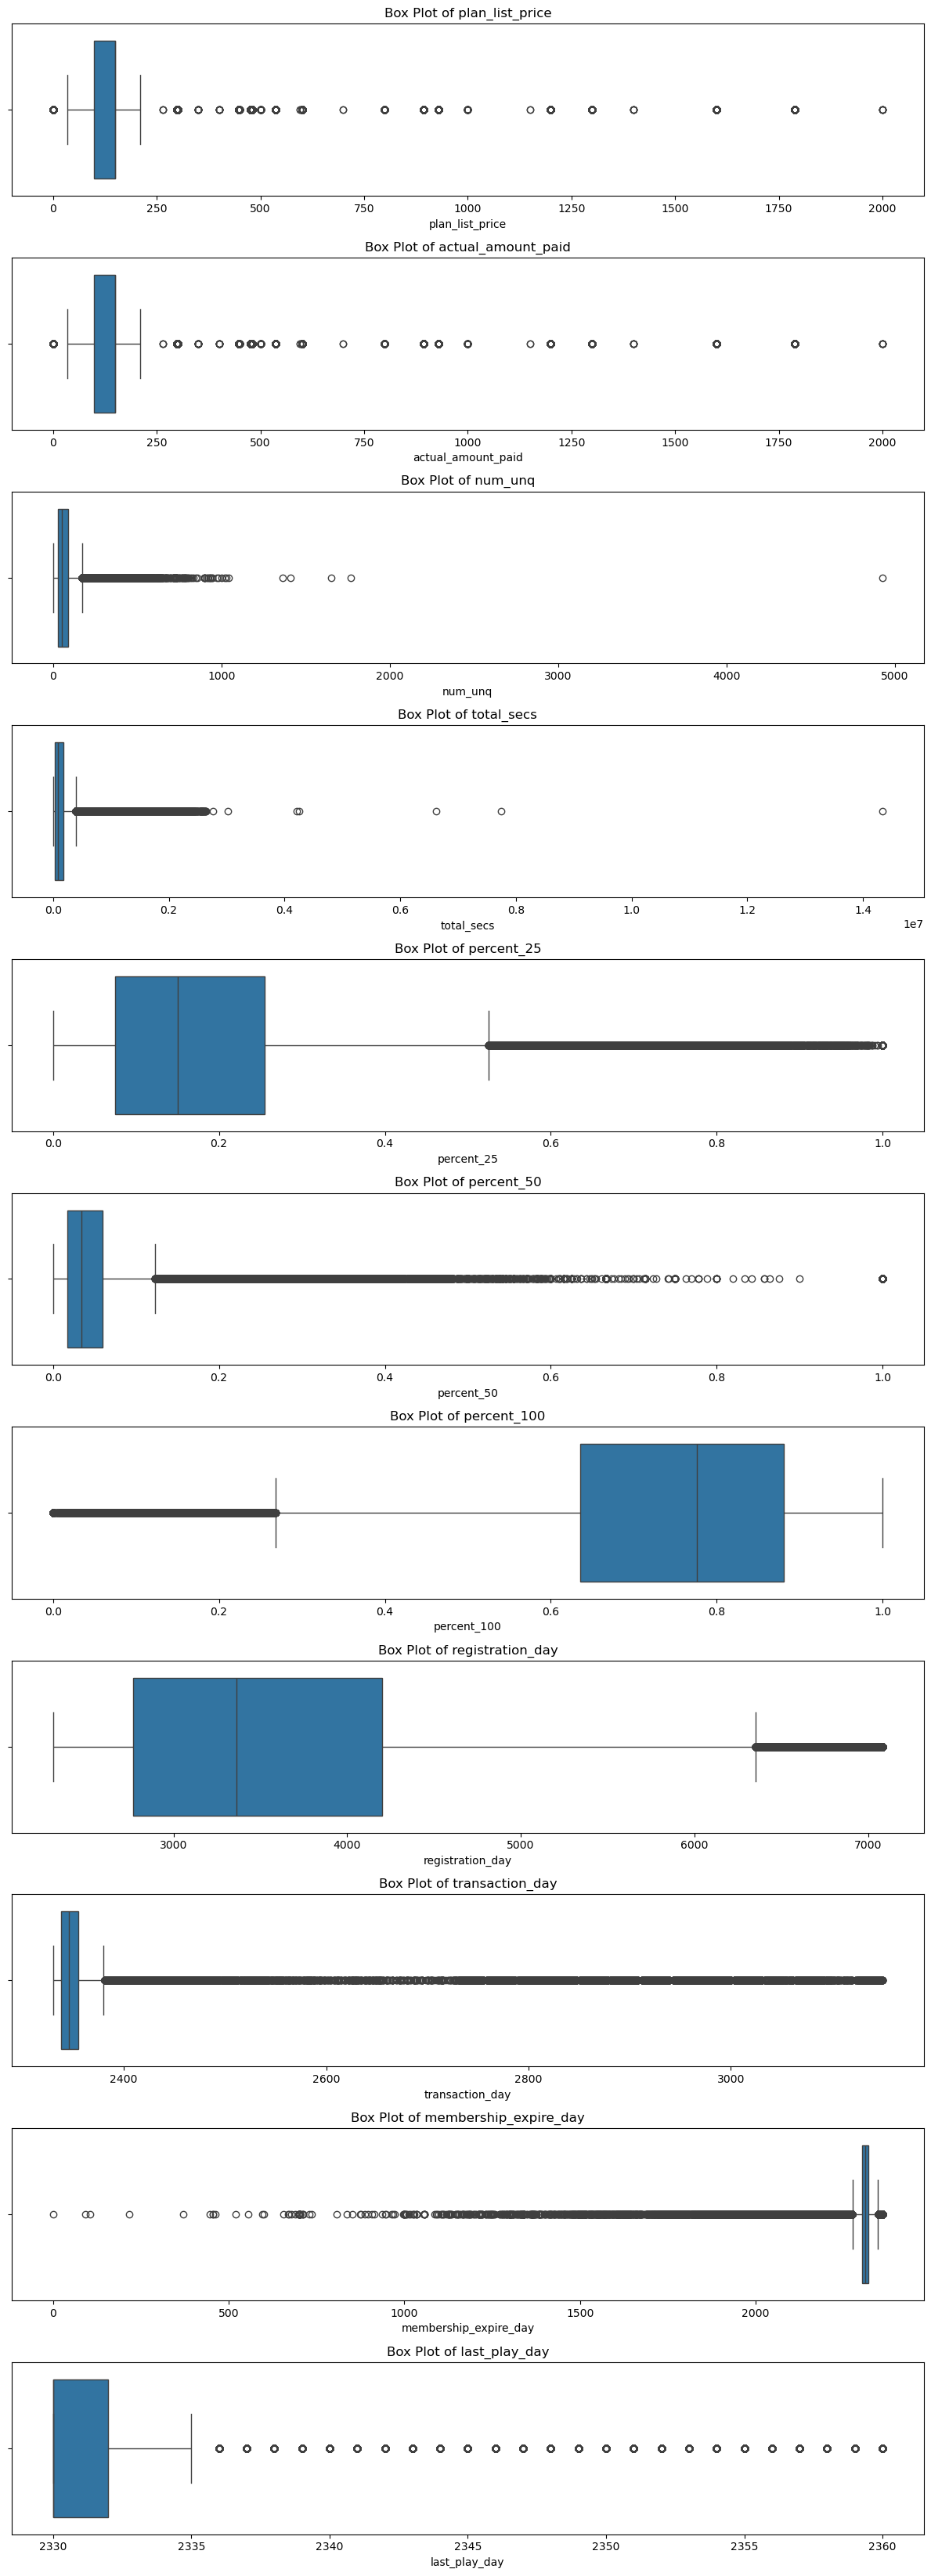

In [32]:
num_cols = ['plan_list_price', 'actual_amount_paid', 'num_unq', 'total_secs', 'percent_25', 'percent_50', 'percent_100', 'registration_day', 'transaction_day', 'membership_expire_day', 'last_play_day']
# Set up the matplotlib figure
plt.figure(figsize=(12, len(num_cols) * 3))

# Loop through the columns and create a box plot for each
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=X[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


# 4. Model training

## 4.1 Random Forest Classifier

In [68]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['plan_list_price', 'actual_amount_paid', 'num_unq', 'total_secs', 'percent_25', 'percent_50', 'percent_100', 'registration_day', 'transaction_day', 'membership_expire_day', 'last_play_day']
categorical_features = ['city', 'registered_via', 'payment_method_id', 'payment_plan_days', 'is_auto_renew', 'is_cancel']

col_thresholds = {
    'city': 0.04,
    'payment_method_id': 0.02,
    'payment_plan_days': 0.03
}

def preprocess_category_columns(df, col_thresholds, missing_value=-1.0, small_category_value=-2.0):
    for col_name in categorical_features:
        df[col_name] = df[col_name].fillna(missing_value)
        if col_name in col_thresholds:
            threshold_percentage = col_thresholds[col_name]
            # print(threshold_percentage)
            total_count = len(df)
            threshold_count = threshold_percentage * total_count
            category_counts = df[col_name].value_counts()
            small_categories = category_counts[category_counts < threshold_count].index
            df[col_name] = df[col_name].replace(small_categories, small_category_value)
    return df

def replace_outliers(df, columns):
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
    return df

def one_hot_encode(df):

    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    return df

def replace_outliers_transform(X):
    return replace_outliers(X, numeric_features)

# Define preprocessing for categorical columns
def preprocess_category_columns_transform(X):
    return preprocess_category_columns(X, col_thresholds=col_thresholds, missing_value=-1.0, small_category_value=-2.0)

one_hot_encode_transformer = FunctionTransformer(one_hot_encode)

numeric_transformer = Pipeline(steps=[
    ('outlier_replacer', FunctionTransformer(replace_outliers_transform, validate=False)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('toCat_fillMissing_combine', FunctionTransformer(preprocess_category_columns_transform, validate=False)),
    ('one_hot_enc', one_hot_encode_transformer)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier())
])

In [56]:
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')

Accuracy: 0.9732687237373321


In [38]:
#get all feature name after preprocess pipline for feature importances
def preprocess_and_one_hot_encode(X):

    X_df = pd.DataFrame(X, columns=categorical_features)
    
    X_df = preprocess_category_columns(X_df, col_thresholds=col_thresholds, missing_value=-1.0, small_category_value=-2.0)
    
    X_df = one_hot_encode(X_df)
    
    return X_df

X_train_cat_preprocessed = preprocess_and_one_hot_encode(X_train[categorical_features])

categorical_features_processed = X_train_cat_preprocessed.columns.tolist()

all_feature_names = numeric_features + categorical_features_processed

print('All feature names:')
print(all_feature_names)


All feature names:
['plan_list_price', 'actual_amount_paid', 'num_unq', 'total_secs', 'percent_25', 'percent_50', 'percent_100', 'registration_day', 'transaction_day', 'membership_expire_day', 'last_play_day', 'city_-1.0', 'city_1.0', 'city_4.0', 'city_5.0', 'city_13.0', 'city_15.0', 'city_22.0', 'registered_via_3.0', 'registered_via_4.0', 'registered_via_7.0', 'registered_via_9.0', 'registered_via_13.0', 'payment_method_id_-1.0', 'payment_method_id_34.0', 'payment_method_id_36.0', 'payment_method_id_37.0', 'payment_method_id_38.0', 'payment_method_id_39.0', 'payment_method_id_40.0', 'payment_method_id_41.0', 'payment_plan_days_-1.0', 'payment_plan_days_30.0', 'is_auto_renew_0.0', 'is_auto_renew_1.0', 'is_cancel_0.0', 'is_cancel_1.0']


In [47]:
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                   Feature  Importance
8          transaction_day    0.152775
9    membership_expire_day    0.132092
32  payment_plan_days_30.0    0.126405
35           is_cancel_0.0    0.104518
36           is_cancel_1.0    0.065749
34       is_auto_renew_1.0    0.062244
0          plan_list_price    0.041929
1       actual_amount_paid    0.040243
31  payment_plan_days_-1.0    0.029169
7         registration_day    0.028246
33       is_auto_renew_0.0    0.025676
10           last_play_day    0.023263
23  payment_method_id_-1.0    0.020160
30  payment_method_id_41.0    0.015214
3               total_secs    0.014575
2                  num_unq    0.014199
6              percent_100    0.013501
4               percent_25    0.013348
5               percent_50    0.013222
12                city_1.0    0.006781
28  payment_method_id_39.0    0.006412
27  payment_method_id_38.0    0.006335
15               city_13.0    0.005258
14                city_5.0    0.004813
29  payment_method_id_40.

## 4.2 Decision Tree

In [49]:
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}')

Decision Tree Accuracy: 0.9643857625442861


In [52]:
# Get feature importances from the DecisionTreeClassifier
feature_importances = dt_pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                   Feature  Importance
32  payment_plan_days_30.0    0.362602
8          transaction_day    0.257715
36           is_cancel_1.0    0.155300
9    membership_expire_day    0.084006
33       is_auto_renew_0.0    0.038472
7         registration_day    0.017022
10           last_play_day    0.012714
1       actual_amount_paid    0.011544
3               total_secs    0.008121
2                  num_unq    0.007702
5               percent_50    0.007273
6              percent_100    0.007086
4               percent_25    0.006392
25  payment_method_id_36.0    0.005567
29  payment_method_id_40.0    0.003933
0          plan_list_price    0.001927
12                city_1.0    0.001588
15               city_13.0    0.001192
20      registered_via_7.0    0.001177
14                city_5.0    0.001098
13                city_4.0    0.000929
17               city_22.0    0.000836
30  payment_method_id_41.0    0.000797
11               city_-1.0    0.000787
18      registered_via_3.

## 4.3 Logistic Regression

In [40]:
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)}')

Logistic Regression Accuracy: 0.9395958638872868


In [41]:
feature_importances = lr_pipeline.named_steps['classifier'].coef_[0]

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                   Feature  Importance
36           is_cancel_1.0    4.973274
33       is_auto_renew_0.0    2.870523
0          plan_list_price    1.638313
8          transaction_day    1.309221
11               city_-1.0    0.926754
34       is_auto_renew_1.0    0.762821
19      registered_via_4.0    0.697590
20      registered_via_7.0    0.654950
22     registered_via_13.0    0.554920
29  payment_method_id_40.0    0.538882
27  payment_method_id_38.0    0.438055
18      registered_via_3.0    0.378527
10           last_play_day    0.291282
21      registered_via_9.0    0.206828
7         registration_day    0.131925
6              percent_100    0.057240
3               total_secs    0.042977
4               percent_25    0.014521
5               percent_50    0.011108
25  payment_method_id_36.0   -0.000959
2                  num_unq   -0.019516
12                city_1.0   -0.073447
30  payment_method_id_41.0   -0.173290
15               city_13.0   -0.185891
13                city_4.

## 4.4 Deep Learning

In [42]:

def create_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

clf = KerasClassifier(build_fn=create_nn_model,input_dim = len(all_feature_names),verbose=0)#deprecated

steps = [
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
     ('clf', clf)
]

dl_pipeline = ImbPipeline(steps=steps)

pipeline_model_dl = dl_pipeline.fit(X_train, y_train)

prediction_dl = pipeline_model_dl.predict(X_test)


In [43]:
accuracy_dl = accuracy_score(y_test, prediction_dl)
print(accuracy_dl)

0.8746137842959545


## 4.5 Hyperparameter tuning for Decision Tree and Rondom Forest

In [60]:
param_grid = {
    'classifier__max_depth': [17,15,20],
}

grid_search_dt = GridSearchCV(estimator=dt_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search_dt.fit(X_train, y_train)

best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print("Best hyperparameters:", best_params_dt)
print("Best score:", best_score_dt)


Best hyperparameters: {'classifier__max_depth': 15}
Best score: 0.97229159680589


In [62]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

print("Best hyperparameters:", best_params)
print("Best score:", best_score)

Best hyperparameters: {'classifier__n_estimators': 200}
Best score: 0.9732043547066349


## 4.6 LightGBM as ensemble method

In [68]:

lgb_estimator = lgb.LGBMClassifier()

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_pipeline), 
        ('dt', dt_pipeline)  
    ],
    final_estimator=lgb_estimator
)

stacking_clf.fit(X_train, y_train)

prediction_stacked = stacking_clf.predict(X_test)



[LightGBM] [Info] Number of positive: 69880, number of negative: 706888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 776768, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.089963 -> initscore=-2.314093
[LightGBM] [Info] Start training from score -2.314093


In [69]:
acc = accuracy_score(y_test, prediction_stacked)
print("Accuracy:", acc)

Accuracy: 0.9744325203921892


# 5. Model interpretation

## 5.1 Permutation importance

In [93]:
# Get permutation importance
result = permutation_importance(stacking_clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

                  feature  importance_mean  importance_std
15  membership_expire_day         0.080969        0.000533
14        transaction_day         0.038337        0.000285
7               is_cancel         0.015721        0.000192
3       payment_plan_days         0.013614        0.000085
2       payment_method_id         0.007281        0.000144
13       registration_day         0.005274        0.000123
16          last_play_day         0.003772        0.000121
6           is_auto_renew         0.003678        0.000077
5      actual_amount_paid         0.001857        0.000046
1          registered_via         0.000938        0.000052
9              total_secs         0.000900        0.000096
4         plan_list_price         0.000577        0.000056
0                    city         0.000005        0.000095
10             percent_25        -0.000077        0.000046
11             percent_50        -0.000170        0.000146
8                 num_unq        -0.000228        0.0000

## 5.2 Gain and lift chart

Decile 1 Lift: 9.75083018435818, Gain: 0.9750830184358181
Decile 2 Lift: 0.14657047978930493, Gain: 0.9897400664147487
Decile 3 Lift: 0.055078438108324745, Gain: 0.9952479102255811
Decile 4 Lift: 0.019809916409023246, Gain: 0.9972289018664835
Decile 5 Lift: 0.008817130424825374, Gain: 0.998110614908966
Decile 6 Lift: 0.0, Gain: 0.998110614908966
Decile 7 Lift: 0.0, Gain: 0.998110614908966
Decile 8 Lift: 0.010420245047520899, Gain: 0.9991526394137181
Decile 9 Lift: 0.005725409366769724, Gain: 0.999725180350395
Decile 10 Lift: 0.0027481964960494676, Gain: 1.0


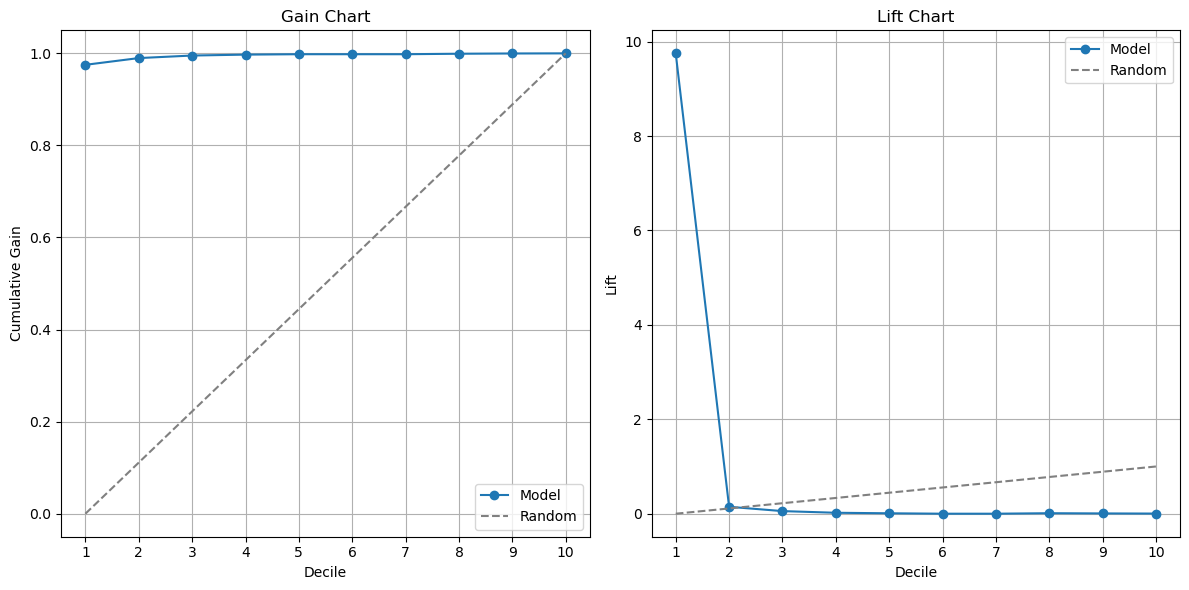

In [95]:
predicted_proba = stacking_clf.predict_proba(X)[:, 1]  
actual_churn = y  

results = pd.DataFrame({'predicted_proba': predicted_proba, 'actual_churn': actual_churn})

results = results.sort_values(by='predicted_proba', ascending=False)

deciles = np.array_split(results, 10)

average_churn_rate = results['actual_churn'].mean()

total_churners = results['actual_churn'].sum()
cumulative_churners = 0
gains = []
lifts = []

for i, decile in enumerate(deciles):
    decile_churners = decile['actual_churn'].sum()
    cumulative_churners += decile_churners
    cumulative_gain = cumulative_churners / total_churners
    gains.append(cumulative_gain)
    lift = (decile_churners / len(decile)) / average_churn_rate
    lifts.append(lift)
    print(f'Decile {i+1} Lift: {lift}, Gain: {cumulative_gain}')

random_line = np.linspace(0, 1, 10)

decile_indices = range(1, 11)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(decile_indices, gains, marker='o', linestyle='-', label='Model')
plt.plot(decile_indices, random_line, linestyle='--', color='gray', label='Random')
plt.xlabel('Decile')
plt.ylabel('Cumulative Gain')
plt.title('Gain Chart')
plt.xticks(decile_indices)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(decile_indices, lifts, marker='o', linestyle='-', label='Model')
plt.plot(decile_indices, random_line, linestyle='--', color='gray', label='Random')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.xticks(decile_indices)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5.3 Surrogate model

In [96]:

y_proba = stacking_clf.predict_proba(X_train)[:, 1]

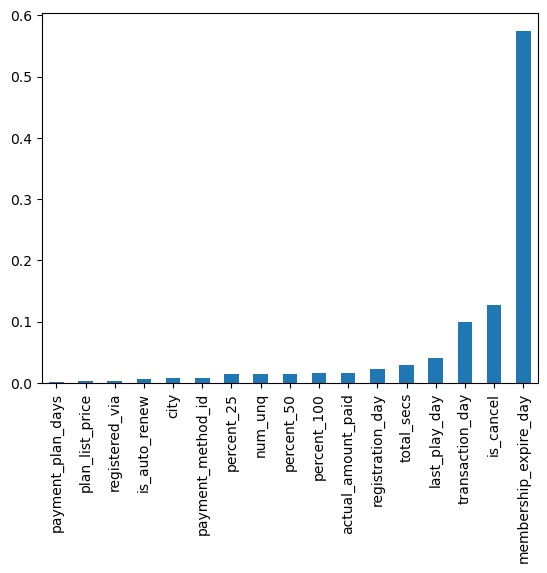

In [97]:


dt = DecisionTreeRegressor()

dt.fit(X_train, y_proba)

pd.Series(dt.feature_importances_, index=X.columns).sort_values().plot(kind='bar');
